<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Connectivity Workshop SWDB 2017 </h1> 
<h3 align="center">Monday, August 21, 2017</h3>
<h3 align="center">Motivating Question: Where do primary visual cortex neurons project?</h3>

In [1]:
# please make sure your drive_path is set, so that the notebook can find the data files on the hard drive

# OS X
# drive_path = '/Volumes/Brain2016/data/dynamic-brain-workshop/mouse_connectivity_cache'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/mouse_connectivity_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2016/data/dynamic-brain-workshop/mouse_connectivity_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/mouse_connectivity_cache/'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Mouse Connectivity SDK</h2>

<p>
Connectivity data can be accessed <a href="http://connectivity.brain-map.org/">on the web</a>. This is useful for browsing and familiarizing yourself with the data, but for more in-depth analyses, it is often better to access data programmatically. The <a href="https://alleninstitute.github.io/AllenSDK/">AllenSDK</a> provides Python-based tools to support that approach, and this notebook will introduce you to them.<p>

<p>
If you have not installed the `allensdk` python module yet, do so from a command prompt:</p>

<p>
   `> pip install allensdk` </p>
    
</div>

In [2]:
# imports!

# pandas for manipulating / viewing tables
import pandas as pd

# numpy, which needs no introduction
import numpy as np

# os for dealing with the file system
import os

# MouseConnectivityCache for downloading and storing mouse connectivity data
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# OntologiesApi
from allensdk.api.queries.ontologies_api import OntologiesApi

# display for nice notebook views
from IPython.display import display

# easy plotting
import matplotlib.pyplot as plt

In [3]:
# settings!

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h3>Where is the primary visual area in the mouse?</h3></center>

We'll answer this question in two ways:
<ul>
<li>relatively: We want to know which structure(s) contain the primary visual.</li>
<li>absolutely: We want to know where the primary visual area is located in physical space.</li>
</ul>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "><h4>The caching pattern:</h4>
<p>We will be using the MouseConnectivityCache class to download and store data. This class requires from us:

<ul>
<li>a manifest file path. This path determines where data will be stored. Once you have instantiated your cache once, you can access downloaded data again by instantiating a new cache with the same manifest path.  We will be using pre-populated data directories.</li>
<ul>
<li><i>A MouseConnectivityCache is used to copy and cache data from the cell types database. If you create the MouseConnectivityCache instance with no arguments, then data is downloaded from the online repository:
mcc = MouseConnectivityCache()</i></li>
<p><li><i>Because we have limited internet bandwidth, the data you need is already provided on your external hard drive and AWS. To ensure this local data is used instead of the online repository, create the MouseConnectivityCache instance using the manifest_file argument:</i></li></p></ul>

<li>a resolution for the data volumes that we will be downloading. The possible (isometric) resolutions are 10, 25, 50, and 100-microns, with 25 the default.</li>
</ul>

<p>As usual, you can use the built in help function to see the complete documentation.</p></div>

In [4]:
# specify your path and isometric resolution
manifest_file = os.path.join(drive_path, 'manifest.json')
resolution = 25

# instantiate the cache object
# after this step, the manifest file you specified should exist on your filesystem
mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "><h3><center>The structure tree</center></h3>
Anatomists at the Allen Institute have divided the adult mouse brain into ~1300 distinct structures. These are arranged in a tree, where coarsely specified structures (e.g. 'Isocortex') are near the root and finely specified structures (e.g "Primary visual area, layer 4") make up the leaves.

<a href="http://atlas.brain-map.org/atlas?atlas=1">Here</a> is a handy visualization of the tree (and atlas!).

<p>You can download and access the structure tree by calling get_structure_tree on your MouseConnectivityCache instance.</div>

In [5]:
# get the structure tree
# this step should produce a file called 'structures.json' in the same directory as your manifest file
structure_tree = mcc.get_structure_tree()

In [6]:
# view the structure record for primary visual cortex
visp = structure_tree.get_structures_by_name(['Primary visual area'])

# the data structure returned by this method is a list of dictionaries:
visp

[{'acronym': u'VISp',
  'graph_id': 1,
  'graph_order': 185,
  'id': 385,
  'name': u'Primary visual area',
  'rgb_triplet': [8, 133, 140],
  'structure_id_path': [997, 8, 567, 688, 695, 315, 669, 385],
  'structure_set_ids': [396673091,
   112905828,
   12,
   184527634,
   514166994,
   112905813,
   114512891,
   114512892,
   167587189]}]

In [7]:
# we can make a nicer table view using pandas:
pd.DataFrame(visp)

,acronym,graph_id,graph_order,id,name,rgb_triplet,structure_id_path,structure_set_ids
0,VISp,1,185,385,Primary visual area,"[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385]","[396673091, 112905828, 12, 184527634, 51416699..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
See <a href='http://alleninstitute.github.io/AllenSDK/_static/examples/nb/reference_space.html'>here</a> for definitions of these fields. The most relevant ones for us right now are:

<ul>
<li>id: A unique integer identifier for this structure</li>
<li>name: The structure's full name</li>
<li>acronym: A shortened version of the structure's name</li>
<li>structure_id_path: a list of structures from the root of the tree (left) to the selected structure record.</li>
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Mapping ids to names</h4>

<p>We can identify a structure by:
<ul>
<li>Its id</li>
<li>Its name</li>
<li>Its acronym</li>
</ul>

<p>Frequently, we want to switch between these. For instance, we might want to know the name of VISp's parent (structure 669 from the structure_id_path). The structure tree can be used to generate a map from ids to names:
</div>

In [8]:
name_map = structure_tree.get_name_map()
parent_id = structure_tree.parent_id([385])[0] # structure tree methods accept and return lists
name_map[parent_id]

u'Visual areas'

In [9]:
# The structure tree also has a built-in map for going from acronyms to ids:
acronym_to_id_map = structure_tree.get_id_acronym_map()
acronym_to_id_map['VISp']

385

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: mapping acronyms to names</h4>

<p>Write a function with the following signature:</p>
</div>

```python
def get_acronym_name_map(structure_tree):
    '''Builds a dictionary mapping structure acronyms to names.
    
    Parameters
    ----------
    structure_tree : StructureTree
        The complete structure tree.
        
    Returns
    -------
    acronym_name_map : dict
        Keys are acronyms (str); values are names (str).
    
    '''
    
    # your code here
    
    return acronym_name_map
```

In [10]:
def get_acronym_name_map(structure_tree):
    return structure_tree.value_map(lambda x: x['acronym'], lambda y: y['name'])

In [11]:
acronym_name_map = get_acronym_name_map(structure_tree)
acronym_name_map['VISp']

u'Primary visual area'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: where is VISp in the structure tree?</h4>

Where is the primary visual area? One way to answer this question would be to name structures containing VISp. These are:
<ol>
<li>Visual Areas</li>
<li>Isocortex</li>
<li>...</li>
<li>root</li>
</ol>

In this excercise we will write a function that determines the nth ancestor of a given structure. Use the following signature:
</div>

```python
def where_in_the_tree(structure_tree, structure_name, steps=1):
    '''Names a structure which contains the supplied structure
    
    Parameters
    ----------
    structure_tree : StructureTree
        The tree in which structures will be looked up.
    structure_name : str
        The name of the structure whose ancestor we wish to find
    steps : int, optional
        How far rootward to walk. 1 gives the direct parent.
        
    Returns
    -------
    ancestor_name : str
        The full name of the requested ancestor structure.
    
    Examples
    --------
    >>>where_in_the_tree(structure_tree, 'Primary visual area', 2)
    u'Isocortex'
    >>>where_in_the_tree(structure_tree, 'Hippocampal formation', 0)
    u'Hippocampal formation'
    >>>where_in_the_tree(structure_tree, 'Cerebrum', 10000)
    None
    '''
    
    # your code here
    
    return ancestor_name

```

In [12]:
def where_in_the_tree(structure_tree, structure_name, steps=1):    
    
    if structure_name in structure_tree.get_name_map().values():
        structure = structure_tree.get_structures_by_name([structure_name])[0]
    else:
        raise ValueError('structure \"{0}\" not found'.format(structure_name))
        
    for step in range(steps):
        structure = structure_tree.parent([structure['id']])[0]
        
        if structure is None:
            return
        
    return structure['name']

In [13]:
print where_in_the_tree(structure_tree, 'Primary visual area', 2)
print where_in_the_tree(structure_tree, 'Hippocampal formation', 0)

Isocortex
Hippocampal formation


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3><center>Working in 3d space</center></h3>

Anatomic variability across mice is a fundamental problem for our connectivity dataset. How can we ask questions about VISp if its location, size, and shape are different on every brain?

<p>We resolved this issue by generating an average template volume from 1675 mouse brain image stacks and registering each of our connectivity datasets to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework</p>

<p>You can view the average template volume using your MouseConnectivityCache:</p>

</div>

(528, 320, 456)


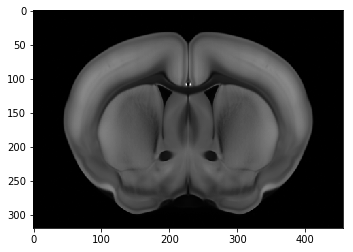

In [14]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution
plt.imshow(template[200, :, :], interpolation='none', cmap=plt.cm.gray)

# how big?
print template.shape

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The template is oriented:</p>
<ul>
<li>anterior -> posterior</li>
<li>superior -> inferior</li>
<li>left -> right</li>
</ul>

<p>This means that to obtain a sagittal view, we must slice along axis 2:</p>
</div>

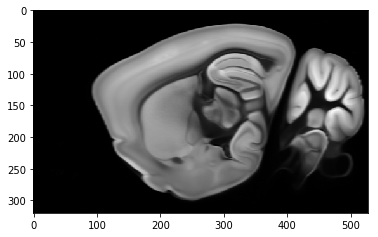

In [15]:
plt.imshow(template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
and along axis 1 for a horizontal section:</div>

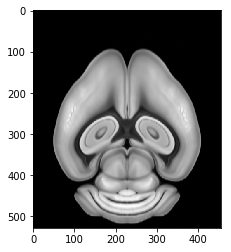

In [16]:
plt.imshow(template[:, 75, :], interpolation='none', cmap=plt.cm.gray)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>The annotation volume</h4>

<p>Each (brain) voxel in the CCF is associated with a structure in the structure tree. This mapping is recorded in the annotation volume, which occupies the same space as the average template. The value of each voxel in the annotation volume is the id of the most specific structure occupying that point in space.</p>
</div>

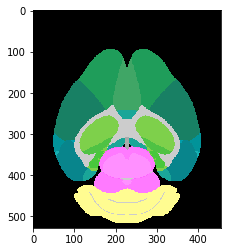

In [17]:
# you can obtain a reference space object from your mouse connectivity cache
# this object handles tasks that require both a structure tree and an annotation volume
reference_space =  mcc.get_reference_space()

# One such task is to apply our predefined structure colors to 
# a slice from the annotation volume
slice_image = reference_space.get_slice_image(1, 1875) # this method wants an axis and a position in microns
plt.imshow(slice_image, interpolation='none')

In [18]:
# you can load up the raw annotation using your MouseConnectivityCache
annotation, _ = mcc.get_annotation_volume()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We want to find VISp, whose structure id is 385. How about:
</div>

In [19]:
np.where(annotation == 385)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Why did nothing show up? Recall that the annotation only labels the finest structure division at each voxel. VISp has several substructures:
</div>

In [20]:
visp_children = structure_tree.children([385])[0]
display(pd.DataFrame(visp_children))

,acronym,graph_id,graph_order,id,name,rgb_triplet,structure_id_path,structure_set_ids
0,VISp6a,1,190,33,"Primary visual area, layer 6a","[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385, 33]","[184527634, 396673091, 12]"
1,VISp6b,1,191,305,"Primary visual area, layer 6b","[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385, 305]","[184527634, 396673091, 12]"
2,VISp1,1,186,593,"Primary visual area, layer 1","[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385, 593]","[184527634, 396673091, 12]"
3,VISp4,1,188,721,"Primary visual area, layer 4","[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385, 721]","[184527634, 396673091, 12]"
4,VISp5,1,189,778,"Primary visual area, layer 5","[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385, 778]","[184527634, 396673091, 12]"
5,VISp2/3,1,187,821,"Primary visual area, layer 2/3","[8, 133, 140]","[997, 8, 567, 688, 695, 315, 669, 385, 821]","[184527634, 396673091, 12]"


In [21]:
# VISp, like other cortical structures, is subdivided into layers. 
# Voxels are directly assigned to the layer structures instead of to VISp
np.where(annotation==821) # 821 <==> VISp layer 2/3

(array([308, 308, 308, ..., 410, 410, 410]),
 array([28, 28, 28, ..., 78, 78, 78]),
 array([123, 124, 125, ..., 116, 340, 341]))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
A couple of caveats regarding the annotation:
<ol>
<li>It is possible for a structure and its substructures to all be directly annotated. An example would be hypothalamus, which has nuclei labeled where and only where they are distinctly identifiable.</li>
<li>Not all structures in the structure tree are annotated or have annotated substructures.</li>
</ol>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Structure masks</h4>

<p>The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:</p>
<ul>
<li>volumes in the common coordinate framework</li>
<li>1 where the annotation is labeled with a structure or its descendants, otherwise 0</li>
</ul>
</div>

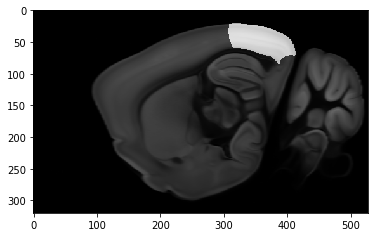

In [22]:
# view a structure mask for VISp
visp_mask, _ = mcc.get_structure_mask(385)
plt.imshow(visp_mask[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray, alpha=0.4)

In [23]:
# we can now easily locate VISp-labeled voxels in space:
np.where(visp_mask)

(array([307, 307, 307, ..., 414, 414, 414]),
 array([23, 23, 24, ..., 78, 78, 78]),
 array([121, 335, 119, ..., 338, 339, 340]))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
It is easy to mask out data. The following syntax will do:
</div>

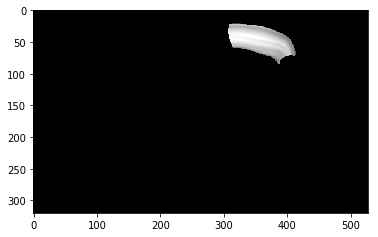

In [24]:
visp_template = template.copy()

# we use 0 here for the masked value because pyplot.imshow doesn't play nice with nan.
# This is not necessarily the right choice for your application!
visp_template[visp_mask == 0] = 0
plt.imshow(visp_template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)

In [25]:
# We can now ask questions about the template while restricting our inquiry to VISp
# for instance, to find the mean voxelwise template intensity within visp:
visp_template.sum() / np.count_nonzero(visp_mask)

175.91918583829698

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: Regional template statistics</h4>

Write a function that computes percentiles of average template intensities in selected structures. Use it to compare the median intensity in white and gray matter.


hint: check out <a href="https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html">numpy's percentile function</a>
</div>

```python
def get_template_intensity_percentiles(mouse_connectivity_cache, structure_ids, n=None):
    '''Computes the nth percentile(s) of the average template volume's intensity within a particular subset of structures.
    
    Parameters
    ----------
    mouse_connectivity_cache : MouseConnectivityCache
    structure_ids : array-like of int
    n : array-like of float, optional
    
    Returns
    -------
    percentiles : array-like of float
        The nth percentiles. Uses the lower value when a percentile falls between two data.
    
    '''
    
    # your code here
    
    return percentiles
    
```

In [26]:
def get_median_template_intensity(mouse_connectivity_cache, structure_ids):
    
    mask = mouse_connectivity_cache.get_reference_space().make_structure_mask(structure_ids)
    template, _ = mouse_connectivity_cache.get_template_volume()
                        
    return np.percentile(template[mask > 0].flat, 50, interpolation='lower')

In [27]:
# find the appropriate ids
structure_tree.get_structures_by_name(['fiber tracts', 'Basic cell groups and regions'])

[{'acronym': u'grey',
  'graph_id': 1,
  'graph_order': 1,
  'id': 8,
  'name': u'Basic cell groups and regions',
  'rgb_triplet': [191, 218, 227],
  'structure_id_path': [997, 8],
  'structure_set_ids': [112905828,
   12,
   184527634,
   112905813,
   114512891,
   114512892]},
 {'acronym': u'fiber tracts',
  'graph_id': 1,
  'graph_order': 1084,
  'id': 1009,
  'name': u'fiber tracts',
  'rgb_triplet': [204, 204, 204],
  'structure_id_path': [997, 1009],
  'structure_set_ids': [184527634, 167587189]}]

In [28]:
gm = get_median_template_intensity(mcc, [8])
wm = get_median_template_intensity(mcc, [1009])

print 'gray: ' + str(gm)
print 'white: ' + str(wm)

gray: 152
white: 48


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h3>Which experiments have injections into VISp?</h3></center>

<p>Now that we have located primary visual cortex in the ontology tree and in physical space, we are ready to look at some connectivity experiments.</p>
<p>On <a href="http://connectivity.brain-map.org">connectivity.brain-map.org</a> you can do a <i>source search</i> to list experiments by the region into which viral tracer was injected. It is possible to do a similar search programmatically using the SDK.</p>
</div>

In [29]:
# get a table of VISp experiments. This is a list of dictionaries.
visp_experiments = mcc.get_experiments(injection_structure_ids=[385])

# get a count
print len(visp_experiments)

203


In [30]:
# look at one of them
visp_experiments[150]

{u'gender': u'M',
 u'id': 482640524,
 u'injection-coordinates': [8770, 830, 4000],
 u'injection-structures': [{u'abbreviation': u'VISp',
   u'color': u'08858C',
   u'id': 385,
   u'name': u'Primary visual area'},
  {u'abbreviation': u'VISpm',
   u'color': u'08858C',
   u'id': 533,
   u'name': u'posteromedial visual area'},
  {u'abbreviation': u'RSPd',
   u'color': u'1AA698',
   u'id': 879,
   u'name': u'Retrosplenial area, dorsal part'},
  {u'abbreviation': u'RSPagl',
   u'color': u'1AA698',
   u'id': 894,
   u'name': u'Retrosplenial area, lateral agranular part'}],
 u'product-id': 36,
 u'strain': u'',
 u'structure-abbrev': u'VISp',
 u'structure-color': u'08858C',
 u'structure-id': 385,
 u'structure-name': u'Primary visual area',
 u'transgenic-line': u'Scnn1a-Tg3-Cre'}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Some particularly important fields here:
<ul>
<li>id : Like structures, each experiment has a unique id.</li>
<li>injection-structures : This is a list of structures that overlapped the injection site. VISp comes first, indicating that it overlapped most heavily. We call VISp the "primary injection site" for this experiment.</li>
<li>transgenic-line : Is this a wildtype mouse, or is fluorescence genetically restricted to a subset of neurons? This mouse is of the Scnn1a-Tg3 line. If it were wildtype, this field would be an empty string.</li>
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h4> Website/SDK Exercise: Locate an experiment on the website using the experiment id</h4>

<p>Find the experiment above on <a href="http://connectivity.brain-map.org">connectivity.brain-map.org</a> and verify that the primary injection structures and transgnic line information matches what you see here.</p>
</div>

<i>The easiest way to do this is to click on any experiment and open its "info" tab by clicking on the i in the top right corner. In the new window that opens up after clicking, paste your experiment id in place of the existing experiment id</i>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; "><h4> Website/SDK Exercise: Find the number of VISp injection experiments that have been performed.</h4>
<p>Verify that you get the same answer using a website search and using the SDK
</div>

<i>This question can be answered either by doing a source search on http://connectivity.brain-map.org or using len(visp_experiments)</i>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: Transgenic line counts</h4>

<p>Many of our projection experiments are carried out in transgenic mice. Infected neurons in these mice fluoresce only if they also express a specific gene. Determine how many VISp experiments were carried out in each transgenic line.</p>

<p>note: we use an empty string for wildtype</p>
</div>

In [31]:
line_counts = {}
for exp in visp_experiments:
    
    tr = exp['transgenic-line']
    
    if tr == '':
        tr = 'wildtype'
    
    if tr not in line_counts:
        line_counts[tr] = 1
    else:
        line_counts[tr] += 1

In [32]:
line_counts

{u'A930038C07Rik-Tg1-Cre': 18,
 u'Ai75(RCL-nT)': 13,
 u'Calb2-IRES-Cre': 1,
 u'Chrna2-Cre_OE25': 5,
 u'Cort-T2A-Cre': 1,
 u'Crh-IRES-Cre (BL)': 1,
 u'Ctgf-2A-dgCre': 1,
 u'Cux2-IRES-Cre': 20,
 u'Drd3-Cre_KI196': 1,
 u'Efr3a-Cre_NO108': 4,
 u'Emx1-IRES-Cre': 18,
 u'Erbb4-2A-CreERT2': 1,
 u'Etv1-CreERT2': 1,
 u'Gad2-IRES-Cre': 1,
 u'Gng7-Cre_KH71': 1,
 u'Gpr26-Cre_KO250': 2,
 u'Htr3a-Cre_NO152': 1,
 u'Nos1-CreERT2': 3,
 u'Nr5a1-Cre': 7,
 u'Ntsr1-Cre_GN220': 15,
 u'Oxtr-Cre_ON66': 1,
 u'Plxnd1-Cre_OG1': 1,
 u'Pvalb-IRES-Cre': 1,
 u'Rbp4-Cre_KL100': 15,
 u'Rorb-IRES2-Cre': 3,
 u'Scnn1a-Tg3-Cre': 10,
 u'Sepw1-Cre_NP39': 2,
 u'Sst-IRES-Cre': 1,
 u'Syt6-Cre_KI148': 5,
 u'Tlx3-Cre_PL56': 15,
 u'Trib2-2A-CreERT2': 2,
 u'Vip-IRES-Cre': 1,
 'wildtype': 31}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; "><h4> Website/SDK Exercise: Find the number of VISp injection experiments that have been performed.</h4>
<p>Cross-check <b>one</b> of these transgenic line experiment counts with what you find on the Allen Institute website.</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h3>Gridded projection data</h3></center>

<p>Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.</p>

Here we will load an experiment's projection density volume. These data:
<ul>
<li>are floats in [0, 1]</li>
<li>represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)</li>
<li>are independent of the injection site (so it makes sense to discuss "projection in the injection site")</li>
</ul>
</div>

In [33]:
prdens, _ = mcc.get_projection_density(159550125)

In [34]:
def axis_proj(data, template, axis, bg_q=90, bg_alpha=0.5):
    # let's make some pictures
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=plt.cm.afmhot)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)

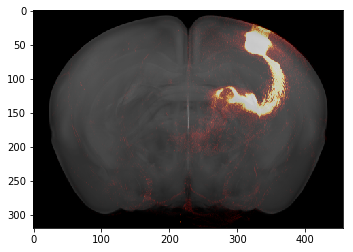

In [35]:
# make a max projection along the anterior-posterior axis for visualization
axis_proj(prdens, template, 0)

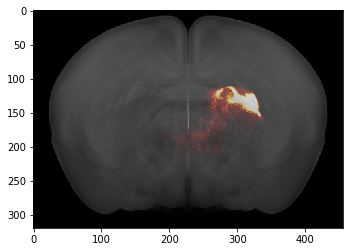

In [36]:
# now filter the signal to thalamus
thalamus_mask, _ = mcc.get_structure_mask(549)

prdens_th = prdens.copy()
prdens_th[thalamus_mask == 0] = 0
axis_proj(prdens_th, template, 0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Another useful data volume is the injection fraction. This shows the fraction of each voxel that lies within this experiment's manually annotated injection site
</div>

In [37]:
ijfr, _ = mcc.get_injection_fraction(159550125)

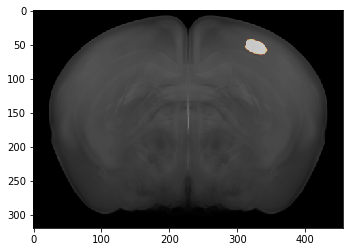

In [38]:
axis_proj(ijfr, template, 0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: Structure-level density</h4>

Write a function that determines the density of signal within a structure (i.e. the fraction of pixels in all the voxels in that structure that were detected as signal). 

In this experiment, what is the density in VISp? What about thalamus?
</div>

```python
def fraction_of_structure(mouse_connectivity_cache, structure_id, experiment_id):
    '''Computes the fraction of pixels in a specified structure that were detected as signal.

    Parameters
    ----------
    mouse_connectivity_cache : MouseConnectivityCache
    structure_id : int
    experiment_id : int

    Returns
    -------
    fraction : float

    '''
    
    # your code here

    return fraction

```

In [39]:
def fraction_of_structure(mouse_connectivity_cache, structure_id, experiment_id):
    
    mask, _ = mouse_connectivity_cache.get_structure_mask(structure_id)
    
    if mask.sum() == 0:
        return 0.0
    
    projection_density, _ = mouse_connectivity_cache.get_projection_density(experiment_id)
    projection_density[mask == 0] = 0
    
    fraction = projection_density.sum() / mask.sum()
    return fraction


In [40]:
print 'thalamus', fraction_of_structure(mcc, 549, 159550125)
print 'VISp', fraction_of_structure(mcc, 385, 159550125)

thalamus 0.0243761871437
VISp 0.075735709711


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h3>Which structures recieve the most projections from VISp?</h3></center>

<p>In order to answer this question you will need a set of structurewise projection summaries. One way to obtain these summary values would be to apply functions like the one you made in the previous excercise across a wider range of structures and experiments. This would be quite time-consuming, so we have precomputed such values for all experiments and structures.</p>

<p>We call these structurewise summary records "unionizes." Each unionize summarizes projection data over a unique (though potentially overlapping) spatial domain. Here are some unionize records:</p>
</div>

In [41]:
sample_experiment = 159550125

unionizes = mcc.get_structure_unionizes(experiment_ids=[sample_experiment])
unionizes.head()

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
0,1,532823925,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000,0.000000,159550125,526157196,7.415590e+09,4.711680e+07,0.0,0.0,0.057718
1,1,532823569,False,0.251098,5500,7150,3300,0.000349,0.000176,0.042345,240.618,0.000056,159550125,639,4.165810e+10,2.580530e+08,10927100.0,45412.8,0.316115
2,1,532823815,False,0.144525,610,5800,5070,0.001465,0.000108,0.023410,216.215,0.000233,159550125,1016,1.202290e+11,1.760170e+09,41206500.0,190581.0,2.156210
3,1,532823422,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000,0.000000,159550125,377,5.533910e+09,3.101040e+07,0.0,0.0,0.037988
4,3,532825286,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000,0.000000,159550125,1010,3.633940e+10,1.636920e+08,0.0,0.0,0.200523


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Each row in this table is a different unionize record. Some of the columns tell you what spatial domain the unionize record summarizes over:
<ul>
<li>structure_id : Which structure does the unionize summarize over?</li>
<li>hemisphere_id* : Does the unionize summarize over the left hemisphere, the right, or both?</li>
<li>is_injection : Does the unionize correspond the the part of this structure which is within the injection site?</li>
</ul>
<p>The "experiment_id" column identifies the experiment from which this unionize's data was drawn. This is not to be confused (!) with the "id" column, which is a unique identifier for this specific unionize record.</p>

<p>All of the other fields are summaries of data. You can find a reference for these <a href='http://alleninstitute.github.io/AllenSDK/unionizes.html'>here</a>. </p>

<p>&#42; the hemisphere ids are: 1 => left, 2 => right, 3 => both</p>
</div>

In [42]:
# You can also obtain al of the unionizes for a given set of experiments
wt_visp_experiment_ids = [exp['id'] for exp in visp_experiments if exp['transgenic-line'] == '']
wt_visp_unionizes = mcc.get_structure_unionizes(wt_visp_experiment_ids)
print wt_visp_unionizes.shape

(70099, 19)


In [43]:
# numeric structure ids are hard to read. Let's use our structure name map from before to 
# add a structure name column to this unionize table
wt_visp_unionizes['structure_name'] = wt_visp_unionizes['structure_id'].map(lambda x: name_map[x])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: Filtering to injection unionizes</h4>

<p>Create a new table which has the same unionize records as wt_vis_unionizes, but filtered down to only those where is_injection is True.</p>

<p>Hint: see the help for MouseConnectivityCache.get_structure_unionizes</p>

</div>

In [44]:
wt_visp_injection_unionizes = mcc.get_structure_unionizes(wt_visp_experiment_ids, is_injection=True)
wt_visp_injection_unionizes.shape

(1558, 19)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>A nonoverlapping set of structures</h4>

<p>A question like "which structures recieve the most projections from VISp" don't make much sense across the whole tree - some structures contain others and will therefore end up higher on the list.</p>

<p>We've created a nonoverlapping list of 293 biologically relevant structures, which we call the "summary structures." You can download a list of summary structures using the ontologies api:</p>
</div>

```python
oapi = OntologiesApi()
summary_structures = oapi.get_structures(structure_set_names="'Mouse Connectivity - Summary'")
summary_structure_ids = [item['id'] for item in summary_structures]
```

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Because of our bandwidth limitations, we will find the summary structure ids using a function from the MouseConnectivityCache structure_tree method. Using the get_structures_by_set_id function, we can access any of the Allen Institute's predefined structure sets by their unique id, which can be found <a href='http://api.brain-map.org/api/v2/data/StructureSet/query.json?'>here</a>. For the "Mouse Connectivity - Summary" structure set, the unique id is 167587189.
</div>

In [45]:
summary_structures = structure_tree.get_structures_by_set_id([167587189])
summary_structure_ids = [item['id'] for item in summary_structures]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now that we have this set of structure ids, we can easily filter our unionizes to just those whose structure is a summary structure.

</div>

In [46]:
wt_visp_summary_unionizes = (
    wt_visp_unionizes[wt_visp_unionizes['structure_id'].isin(summary_structure_ids)])
print wt_visp_summary_unionizes.shape

(27461, 20)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>What are the projection targets of VISp?</h4>

<p>Now that we have a dataframe containing the unionize data outside the injection site for all our experiments in wild type mice, we can use some pandas functions to look at our results. Pandas makes it easy to:</p>
<ol>
<li>Find the mean projection strength by structure across experiments using <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html'>pandas.DataFrame.groupby</a> combined with <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html'>pandas.DataFrame.mean</a></li>
<li>Find the regions that receive the strongest projections using <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html'>pandas.DataFrame.sort_values</a></li>
<li>Graph the data</li>
</ol>
</div>

In [47]:
def top_projection(unionizes, measure, n, group_by='structure_name'):
    '''A helper function for listing the top n structures by the average of some data measure
    '''
    
    grouped = unionizes.groupby(group_by, as_index=False)[measure].mean()
    return grouped.sort_values(by=measure, ascending=False)[:n]

In [48]:
# Since we are looking at projection targets, we want is_injection to be False
# When we have multiple conditions on a pandas dataframe, they can be chained together in a single slice

wt_visp_summary_projection_unionizes = (
    wt_visp_unionizes[(wt_visp_unionizes['is_injection'] == False) & 
                      (wt_visp_unionizes['structure_id'].isin(summary_structure_ids))
                     ])

In [49]:
# get the top 20 targets of VISp using our helper function
top20_density = top_projection(wt_visp_summary_projection_unionizes, 'projection_density', 20)
top20_density['structure_name']

110                                  Lateral visual area
53         Dorsal part of the lateral geniculate complex
279       Ventral part of the lateral geniculate complex
219                                  Primary visual area
203                           Posterolateral visual area
92     Intergeniculate leaflet of the lateral genicul...
112                              Laterointermediate area
145                           Nucleus of the optic tract
241                                Subgeniculate nucleus
18                             Anterolateral visual area
205                                      Postrhinal area
102            Lateral posterior nucleus of the thalamus
230                            Rostrolateral visual area
292                            posteromedial visual area
98                    Lateral dorsal nucleus of thalamus
159                            Olivary pretectal nucleus
20                              Anteromedial visual area
14                            A

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">This list is a little hard to read. Let's make a bar plot.</div>

In [73]:
def plot_mean_values(un, structure_names, measures, colors=None, include_stdev=False, plot_height=4):
    '''A helper function for making shared-axis bar plots from structure unionize data
    
    Parameters
    ----------
    un : pd.DataFrame
        A table of unionizes. It must have a 'structure_name' column.
    structure_names : list of str
        include only data from these structures
    measures : list of str
        Each specifies a kind of data (unionize column). One plot will be generated per measure.
    colors : list of str, optional
        The color of the bars in each plot. If None (default), all of them will be dark blue.
    include_stdev : bool
        If true (default false), standard-deviation based error bars will be added to the plots.
    plot_height : numeric, optiona
        Height of each subplot in inches (your experience may vary). Default is 4.
    '''

    nplots = len(measures)
    
    if colors is None:
        colors = ['darkblue'] * nplots
    
    structure_names = list(structure_names)
    un = un[un['structure_name'].isin(structure_names)]
    
    fig, ax = plt.subplots(nplots, 1, sharex=True, figsize = (15, plot_height * len(measures)))
    for ii, mm in enumerate(measures):
        grouped = un.groupby('structure_name', as_index=False)
        gmeans = grouped[mm].mean()
        
        if nplots == 1:
            axis = ax
        else:
            axis = ax[ii]
        
        if include_stdev:
            gdevs = grouped[mm].apply(np.std, ddof = 0)
            gmeans.plot.bar('structure_name', mm, ax=axis, color=colors[ii], yerr=[gdevs])
        else:
            gmeans.plot.bar('structure_name', mm, ax=axis, color=colors[ii])
            
        axis.set_ylabel(mm)

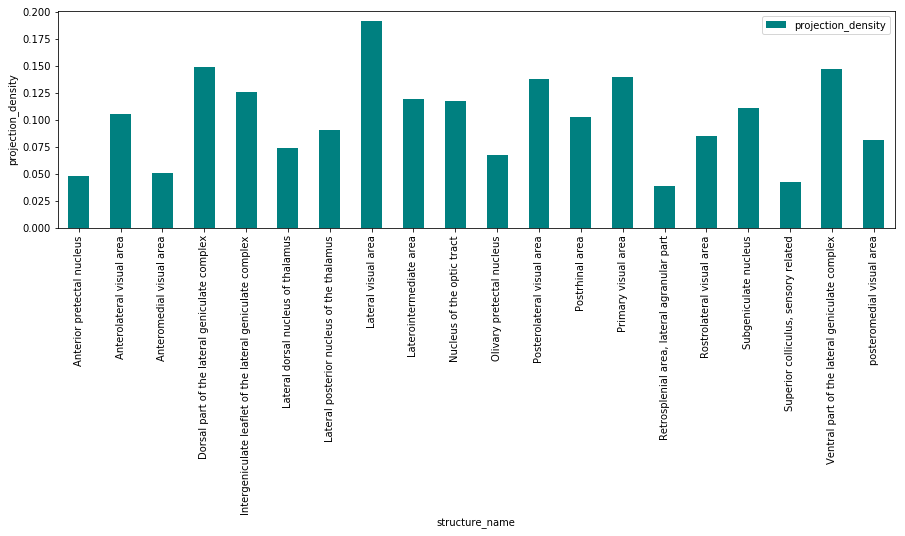

In [74]:
names_of_interest = set(top20_density['structure_name'])
plot_mean_values(wt_visp_summary_projection_unionizes, names_of_interest, 
                 ['projection_density'], ['teal'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Excercise: Comparing projection density and projection volume</h4>

<p>Use the above function to find the top 20 targets of VISp by normalized projection volume.</p>
<ul>
<li>Are these regions different from the top 20 targets by density?</li>
<li>Which targets are different? Hint: try casting the name column to a python set and using the "-" operator.</li>
<li>Which gives us the correct answer for the top 20 projection targets of primary visual cortex?</li>
</ul>
</div>

In [50]:
top20_npv = top_projection(wt_visp_summary_projection_unionizes, 'normalized_projection_volume', 20)
top20_npv['structure_name']

219                               Primary visual area
291                                      fiber tracts
32                                       Caudoputamen
110                               Lateral visual area
225                   Retrosplenial area, dorsal part
102         Lateral posterior nucleus of the thalamus
53      Dorsal part of the lateral geniculate complex
254                Superior colliculus, motor related
205                                   Postrhinal area
255              Superior colliculus, sensory related
226        Retrosplenial area, lateral agranular part
230                         Rostrolateral visual area
203                        Posterolateral visual area
292                         posteromedial visual area
98                 Lateral dorsal nucleus of thalamus
18                          Anterolateral visual area
14                         Anterior pretectal nucleus
279    Ventral part of the lateral geniculate complex
112                         

In [51]:
set(top20_npv['structure_name']) - set(top20_density['structure_name'])

{u'Caudoputamen',
 u'Retrosplenial area, dorsal part',
 u'Superior colliculus, motor related',
 u'fiber tracts'}

In [52]:
set(top20_density['structure_name']) - set(top20_npv['structure_name'])

{u'Intergeniculate leaflet of the lateral geniculate complex',
 u'Nucleus of the optic tract',
 u'Olivary pretectal nucleus',
 u'Subgeniculate nucleus'}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">

Now plot both sets of results (you can use the above plotting function). Use all structures that appeared in either of the top-20 lists.

<p>Recall that | is the union operator on python sets.</p>

</div>

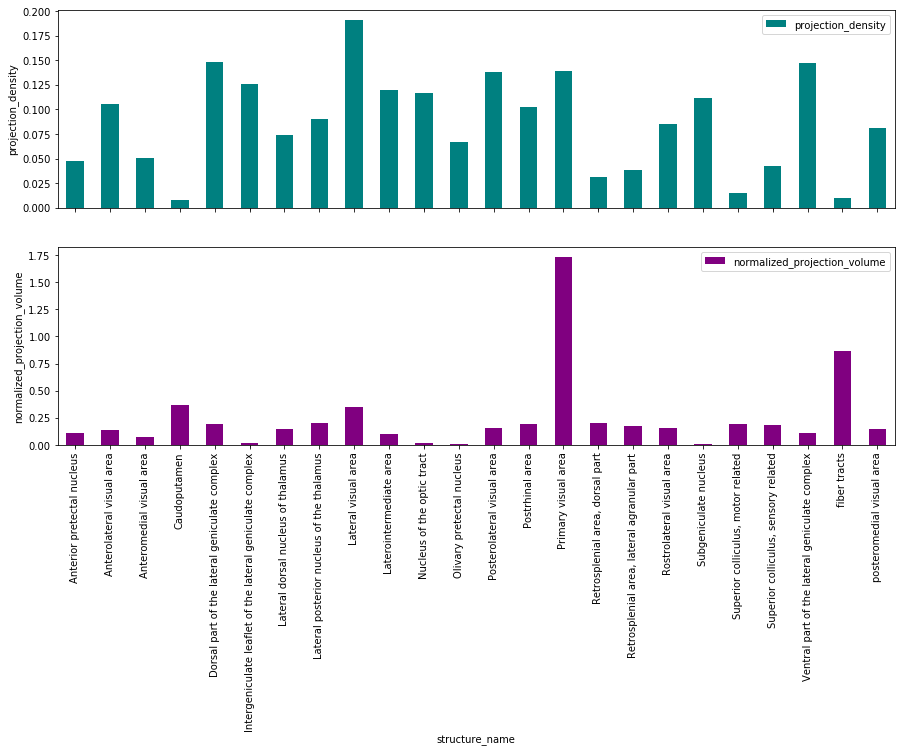

In [55]:
names_of_interest = list(set(top20_density['structure_name']) | set(top20_npv['structure_name']))
plot_mean_values(wt_visp_summary_projection_unionizes, names_of_interest, 
                 ['projection_density', 'normalized_projection_volume'], 
                 ['teal', 'purple'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "><h4>Why do we get different answers with projection density and normalized projection volume?</h4>
<ul>
<li>projection_volume is the volume of projecting signal in mm3 (detected pixels)</li>
<li><u>normalized_projection_volume</u> is the projection_volume / volume of injection site</li>
<li><u>projection_density</u> is the sum of all detected pixels / volume of structure</li>
<li>projection_energy: sum of detected pixel intensity / volume of structure (in general, do not use this)</li>
</ul>

<p>Please see <a href='http://help.brain-map.org/display/mouseconnectivity/API#API-ProjectionDataGridding'>the documentation</a> for more information.</p>

<p>When deciding which measurement to use, think about whether your question is source-centric or target-centric and about how structure sizes might affect your results </p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: Summarizing across experiments</h4>

Write a function that computes a summary statistic across all experiments within a particular spatial domain. Pick a non-VISp structure and evaluate the normalized projection volume (volume of projection signal / volume of injection signal) in that structure across all VISp experiments in wild type mice.

hint: passing a function as an argument seems weird, but you can actually just call the resulting object. For instance, in the below signature calling fn(x) is equivalent to calling np.mean(x)
</div>

```python
def signal_summary(unionizes, structure_id, hemisphere_id, is_injection, signal_key, fn=np.mean):
    '''Applies a function to all unionizes describing a specified spatial domain.
    
    Parameters
    ----------
    unionizes : pd.DataFrame
    structure_id : int
        filter unionizes by structure
    hemisphere_id : int
        filter unionizes by hemisphere
    is_injection : bool
        filter unionizes by injection status
    signal_key : str
        select this column from the data
    fn : function, optional
        apply this function to the values of the resulting pandas series. Defaults to np.mean.
    
    Returns
    -------
    summary : numeric
        output of fn on filtered unionizes
    
    '''
 
    # code here
    
    return summary

```

In [56]:
def signal_summary(unionizes, structure_id, hemisphere_id, is_injection, signal_key, fn=np.mean):
    return fn(unionizes[(unionizes['structure_id'] == structure_id) 
                        & (unionizes['hemisphere_id'] == hemisphere_id)
                        & (unionizes['is_injection'] == is_injection)][signal_key])


In [57]:
signal_summary(wt_visp_unionizes, 170, 3, False, 'normalized_projection_volume')

0.2936064064516129

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise: projection pattern comparisons</h4>

<p>Use the grid and/or unionize data to run a comparison of projection patterns between experiments varying along axes of your choice. Some options:</p>
<ul>
<li>cre line</li>
<li>injection hemisphere</li>
<li>primary injection structure</li>
<li>secondary injection structures, given a common primary injection structure</li>
</ul>
<p>As outputs you might look at:</p>
<ul>
<li>which structures are projected to</li>
<li>are projections equally strong across hemispheres?</li>
<li>do projections preferentially end up in subregions of the target structures? Can these subregions be identified as substructures in the tree, or only geographically?</li>
<li>Which regions are the most or least variably projected to by projections from a particular source?</li>
</ul>
</div>

In [58]:
cux2_visp_experiment_ids = [exp['id'] for exp in visp_experiments if exp['transgenic-line'] == 'Cux2-IRES-Cre']
cux2_visp_unionizes = mcc.get_structure_unionizes(cux2_visp_experiment_ids)

In [59]:
left_volume = np.zeros(annotation.shape)
right_volume = np.zeros(annotation.shape)
valid_cux2 = 0
valid_wt = 0

lr_mid = int(np.around(left_volume.shape[2] / 2))

for ex in visp_experiments:
    
    if ex['transgenic-line'] == 'Cux2-IRES-Cre':
        try:
            prd, _ = mcc.get_projection_density(ex['id'])
            left_volume += prd
            valid_cux2 += 1
        except:
            continue
        
    elif ex['transgenic-line'] == '':
        try:
            prd, _ = mcc.get_projection_density(ex['id'])
            right_volume += prd
            valid_wt += 1
        except:
            continue
left_volume = left_volume / valid_cux2
right_volume = right_volume / valid_wt

average projections from Cux2-Cre experiments, n = 19


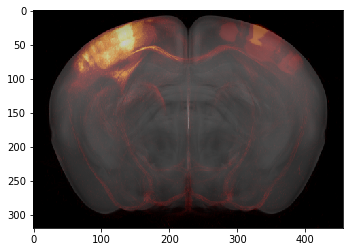

In [60]:
print('average projections from Cux2-Cre experiments, n = %s' %valid_cux2)
axis_proj(left_volume, template, 0)

average projections from wild type experiments, n = 31


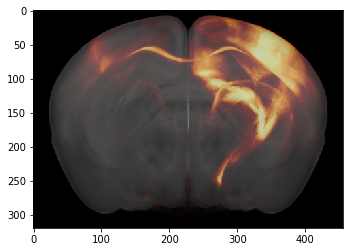

In [61]:
print('average projections from wild type experiments, n = %s' %valid_wt)
axis_proj(right_volume, template, 0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3><center>Additional excercises</center></h3>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4> Excercise 1: most recent common ancestor</h4>

<p>The goal of this excercise is to write a function with the following signature:</p>
</div>

```python
def get_most_recent_common_ancestor(structure_tree, structure_ids):
    '''Finds the most leafward structure that is an ancestor (inclusive) of a set of supplied structures.
    
    Parameters
    ----------
    structure_tree : StructureTree
        The complete structure tree.
    structure_ids : list of int
        One or more structure identifiers 
    
    Returns
    -------
    common_ancestor_id : int
        Structure id of the most specific ancestor of all supplied structures.
    
    Examples
    --------
    >>> get_most_recent_common_ancestor(structure_tree, [385, 425])
    669
    >>> get_most_recent_common_ancestor(structure_tree, [315])
    315
    >>> get_most_recent_common_ancestor(structure_tree, [])
    None
    
    '''

    # your code here

    return common_ancestor_id
```
<p><i>Hint: see StructureTree.ancestor_ids. How are the ids returned by this function ordered?</i></p>

In [62]:
# a possible solution

def get_most_recent_common_ancestor(structure_tree, structure_ids):

    if len(structure_ids) == 0:
        return None
    
    ancestor_ids = structure_tree.ancestor_ids(structure_ids)
    common = reduce(lambda a, b: a & b, map(set, ancestor_ids))
    
    for sid in ancestor_ids[0]:
        if sid in common:
            return sid # ok, so the return is different :p


In [63]:
print get_most_recent_common_ancestor(structure_tree, [385, 425])
print get_most_recent_common_ancestor(structure_tree, [315])
print get_most_recent_common_ancestor(structure_tree, [])

669
315
None


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Excercise 2: Variability between experiments</h4>

<p>Find the standard deviation and/or SEM for the projection densitiy and normalized projection volume in the top 20 sources plotted above. Add error bars to the plot.</p>

<p>Which of these measures is more reliable? What about if you also check the (non-normalized) projection_volume?</p>

</div>

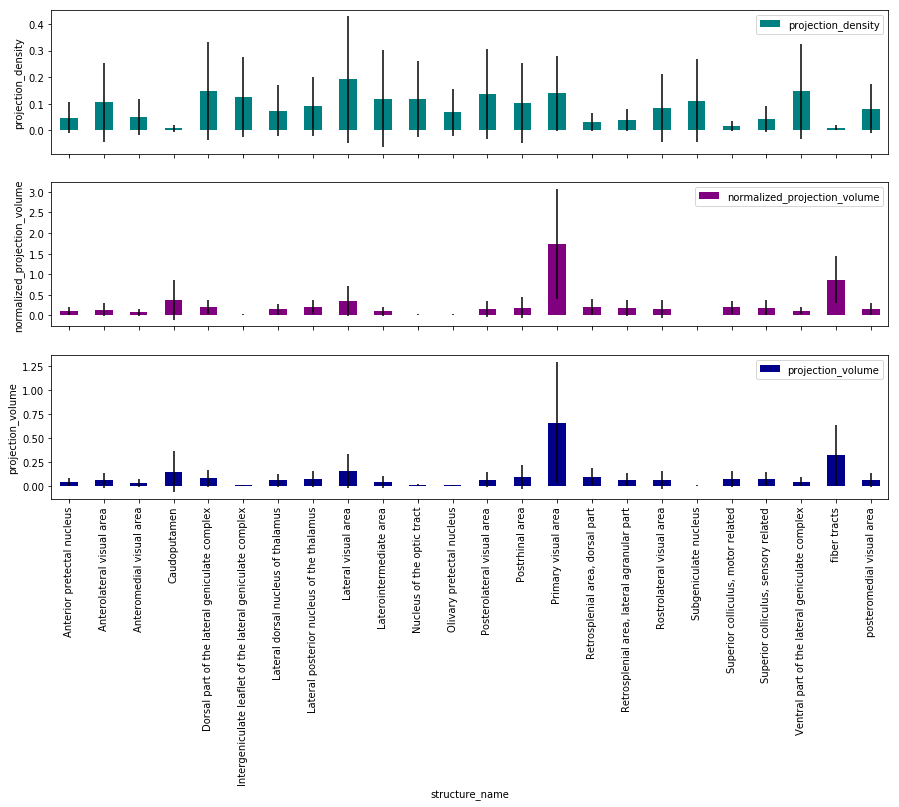

In [76]:
names_of_interest = list(set(top20_density['structure_name']) | set(top20_npv['structure_name']))
plot_mean_values(wt_visp_summary_projection_unionizes, names_of_interest, 
                 ['projection_density', 'normalized_projection_volume', 'projection_volume'], 
                 ['teal', 'purple', 'darkblue'], True, plot_height=3) 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Excercise 3: Correlation between experiments</h4>
<p>Get the projection density volumes for two experiments and compute the correlation coefficient between the two.</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 4: Comparing wild type projection data with cre-defined projection data.</h4>
<p>Pick a region that has injection experiments in both wild type and cre mice. Compare the projections from the cre injection to the wild type projections using the visualization tool of your choice (bar plot, box plot, axis projection, matrix, etc...).</p>
<ul>
<li>Bonus 1: How far apart in space are the cre and wild type injections? Would you consider them to be well-matched?</li>
<li>Bonus 2: Are there any cre lines which have more projection targets than their corresponding wild type experiments? If so, is this true only in some regions or is it a general phenomenon?</li>
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 5: Relationship between structure size and projection density</h4>

<p>Because projection density is normalized by the volume of target structures, smaller structures that receive fewer projections overall may show a greater disparity between normalized_projection_volume and projection_density. Is this true for the targets of VISp? What is the relationship between structure size and projection density?</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 6: Structure based correlation search</h4>
<ul>
<li>Pick several experiments delivered into MOp.</li>
<li>Get the projection density values for all structures at the "Summary" level</li>
<li>Build an experiment-experiment correlation matrix based on those values.</li>
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 7: Reciprocal connections</h4>

<p>Of the top 20 projection targets of VISp (or your favorite region), which ones show reciprocal connections (project back to VISp)? Is the strength of the feedback projections proportional to the strength of the feedforward projections?</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Excercise 8: Generating a Projection Matrix</h4>

<p>The Mouse Connectivity Cache has a built-in function for generating a projection matrix (example below). Use the functions in structure_tree to generate matrices at different levels of detail. Make a projection matrix for:</p>
<ul>
<li>Contralateral projections from VISp</li>
<li>The 293 summary structures</li>
<li>Structures in the thalamus</li>
<li>All descendants of VISp</li>
</ul>
</div>

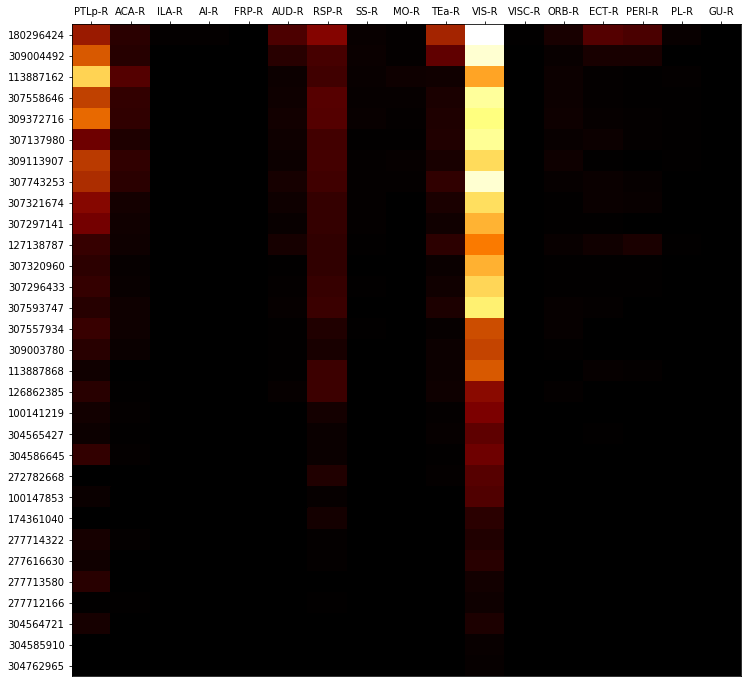

In [65]:
ctx_children = [struct['id'] for struct in structure_tree.children([acronym_to_id_map['Isocortex']])[0]]

pm = mcc.get_projection_matrix(experiment_ids = wt_visp_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(12,12))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3><center>Ideas for shareable functions</center></h3>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<ol>
<li>Find the top n targets for an input source region</li>
<li>Find the top n sources that project to an input target region (or sources with projections stronger than a specified threshold)</li>
<li>Find the top n differences between two or more experiments</li>
<li>Quantify projection density by layer from a specified source to one or more target regions</li>
<li>Find all experiments within a specified distance of an anchor experiment
</ol>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3><center>Project Ideas</center></h3>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Projection Patterns</h4>
<ul>
<li>What are the pathways through the brain from sensory input to motor output?</li>
<li>What are the paths through the brain for incoming sensory information of different modalities? Where do they converge?</li>
<li>Hierarchical streams of cortical processing (for example in the visual cortex) is a successful model in the primate (Felleman and Van Essen). Is there evidence for a similar organization in the mouse (in the connectivity data set)?</li>
</ul>

<h4>Cell Types</h4>
<ul>
<li>Which layers and cre lines have contralateral projections? Does the density of contralateral projections vary by region? How do the targeted contralateral regions differ from targeted ipsilateral regions?</li>
<li>What do different cell types contribute to the network topology?</li>
</ul>

<h4>Topology</h4>
<ul>
<li>Many brain structures have known cortical projection topography including thalamus, superior colliculus, striatum, and primary motor cortex. Does an informatically-driven structure atlas look different when using projection-as-source data to define regions, as opposed to projection-as target (i.e. is there a difference in topology for incoming and outgoing projections in some regions)?</li>
<li>What structural motifs are present in the connectivity data set? How do they differ across regions?</li>
<li>What are the functional correlates to the structural connectivity? How do they relate to models of information processing?</li>
<li>Starting at a given point in the brain, what are the loop back routes and motifs to traverse the network and return to the same spot?</li>
<li>If you lose one particular cell type or cre line (say, due to a particular neurodegenerative disease), what happens to the routes and motifs in the rest of the network?</li>
</ul>

<h4>Methodology</h4>
<ul>
<li>In some cases, replicate experiments have very similar projection patterns while in other cases the difference between experiments is quite high. There are many experimental factors that contribute to this variability including the precise locations of injections, differences in injection size and depth, etc. Are there ways to quantify and/or control for these experimental variables in order to get a sense for the biological variability between animals? Which factors produce the largest differences between experiments (and are therefore most important to control when comparing across experiments)?</li>
<li>Most of the viral tracing experiments in the Allen Mouse Brain Connectivity Atlas use cytosolic GFP as a fluorescent indicator. This tracer produces fluorescent signal in axonal fibers as well as in synapses, so the quantified values are contaminated to some extent by fibers of passage. We have performed ~100 tracing experiments using a synaptophysin-eGFP virus (filter for Syp-EGFP under "Tracer Type"), which is a chimeric protein that is trafficked to synapses and has lower fluorescence in axons. How does the quantified projection data from this synaptic tracer differ from the traditional GFP tracer? Are some regions more contaminated by fibers of passage than others? Remember that the sources of variability listed above still apply here.</li>
</ul>
</div>